In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import os

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)


2.3.1


In [3]:
emotion_label = 'mouth'

In [4]:
# fetch data from records
folder = f'data/landmark_records/{emotion_label}'
print(f'{folder} exists: {os.path.exists(folder)}')

data/landmark_records/mouth exists: True


In [5]:
records_number = len(os.listdir(folder))
print(records_number)

18


In [6]:
records = []
for i in range(records_number):
    with open(f'{folder}/record_{i}.pickle','rb') as pickle_in:
        record = pickle.load(pickle_in)
    records.append(record)

In [7]:
records[0]

[(0.006602358818054199,
  array([[148, 130],
         [150, 146],
         [153, 162],
         [156, 178],
         [161, 194],
         [168, 208],
         [178, 220],
         [190, 228],
         [205, 230],
         [220, 227],
         [232, 218],
         [241, 206],
         [248, 191],
         [251, 175],
         [254, 159],
         [257, 143],
         [257, 127],
         [154, 112],
         [161, 103],
         [172, 100],
         [184, 100],
         [195, 104],
         [215, 105],
         [225, 101],
         [236, 101],
         [245, 104],
         [251, 112],
         [207, 120],
         [208, 130],
         [209, 141],
         [210, 152],
         [197, 162],
         [202, 164],
         [208, 165],
         [213, 164],
         [217, 162],
         [168, 122],
         [174, 117],
         [183, 118],
         [190, 123],
         [182, 125],
         [174, 125],
         [218, 124],
         [225, 119],
         [233, 118],
         [240, 122],
         [

In [8]:
def detail_point_id(id):
    id += 1
    if id <= 17:
        return f'contour_visage_{id}'
    if id <= 22:
        return f'sourcil_droit_{id}'
    if id <= 27:
        return f'sourcil_gauche_{id}'
    if id <= 31:
        return f'crete_nez_{id}'
    if id <= 36:
        return f'bas_nez_{id}'
    if id <= 42:
        return f'oeil_droit_{id}'
    if id <= 48:
        return f'oeil_gauche_{id}'
    if id <= 60:
        return f'levres_exterieur_{id}'
    if id <= 68:
        return f'levres_interieur_{id}'

In [9]:
LANDMARK_SIZE = 68
points_detailed_names = list(map(detail_point_id,range(LANDMARK_SIZE)))
dataset_columns = ['mu'] + [f'{point_name}_{coord}' for point_name in points_detailed_names for coord in ['x','y']]

In [10]:
number_of_landmarks = sum([len(record) for record in records])
print(number_of_landmarks)

951


In [ ]:
def normalize_

In [11]:
data = np.ndarray((number_of_landmarks, 2*LANDMARK_SIZE+1), dtype=object)
landmarks = [(mu,landmark) for record in records for mu,landmark in record]
for i, (mu,landmark) in enumerate(landmarks):
    data[i][0] = mu
    for j,coord in enumerate(landmark.flatten()):
        data[i][j+1] = float(coord)

In [12]:
raw_dataset = pd.DataFrame(data, columns = dataset_columns)

In [13]:
dataset = raw_dataset.copy()

In [14]:
dataset.isna().sum()

mu                       0
contour_visage_1_x       0
contour_visage_1_y       0
contour_visage_2_x       0
contour_visage_2_y       0
                        ..
levres_interieur_66_y    0
levres_interieur_67_x    0
levres_interieur_67_y    0
levres_interieur_68_x    0
levres_interieur_68_y    0
Length: 137, dtype: int64

In [15]:
²

In [16]:
train_dataset

,mu,contour_visage_1_x,contour_visage_1_y,contour_visage_2_x,contour_visage_2_y,contour_visage_3_x,contour_visage_3_y,contour_visage_4_x,contour_visage_4_y,contour_visage_5_x,...,levres_interieur_64_x,levres_interieur_64_y,levres_interieur_65_x,levres_interieur_65_y,levres_interieur_66_x,levres_interieur_66_y,levres_interieur_67_x,levres_interieur_67_y,levres_interieur_68_x,levres_interieur_68_y
153,0.942247,177,119,175,139,175,159,178,177,185,...,255,183,255,192,254,201,249,203,245,203
108,0.061051,181,118,180,137,180,156,183,173,189,...,262,184,265,188,261,187,257,187,252,186
193,0.687944,179,108,174,125,172,142,173,160,177,...,237,176,240,189,236,192,230,191,225,189
689,0.382119,191,88,192,103,195,119,198,133,202,...,249,131,257,138,249,141,243,142,237,141
94,0.816122,120,129,121,144,123,159,127,173,133,...,174,184,183,191,174,194,169,195,165,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0.159438,237,180,242,198,248,215,255,232,263,...,322,228,333,227,322,230,316,232,310,232
15,0.300591,148,129,150,146,153,162,157,179,161,...,211,184,219,189,211,193,206,194,200,194
934,0.717432,58,133,55,153,54,173,56,193,60,...,104,212,116,227,104,239,97,240,90,238
60,0.160725,114,133,115,149,119,165,124,179,130,...,168,188,180,191,169,195,163,196,158,195


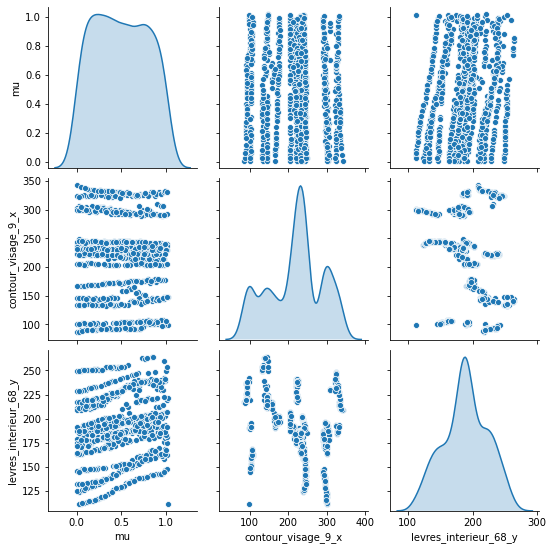

In [17]:
sns.pairplot(train_dataset[['mu','contour_visage_9_x','levres_interieur_68_y']], diag_kind='kde')

In [18]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [19]:
train_labels = train_features.pop('mu')
test_labels = test_features.pop('mu')

In [20]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
normalizer.mean.numpy()

array([156.09987 , 120.75033 , 156.93956 , 139.12221 , 159.6636  ,
       157.4954  , 164.04468 , 175.19843 , 170.51906 , 191.62286 ,
       179.15112 , 206.98555 , 190.34035 , 220.08147 , 203.57819 ,
       229.45992 , 219.23653 , 232.21288 , 234.54796 , 228.81602 ,
       247.87254 , 218.88042 , 258.70435 , 205.04993 , 267.12747 ,
       189.37451 , 273.30225 , 172.47832 , 277.23392 , 154.73062 ,
       279.1879  , 136.72931 , 279.0105  , 118.93561 , 166.55322 ,
        96.71879 , 173.8975  ,  87.374504, 184.98424 ,  83.492775,
       197.21025 ,  83.74245 , 208.20236 ,  88.55585 , 228.29172 ,
        88.89093 , 239.26807 ,  84.44021 , 251.14455 ,  84.14849 ,
       261.8213  ,  88.08541 , 268.50723 ,  96.99212 , 219.22865 ,
       105.73193 , 219.77003 , 116.06702 , 220.43495 , 126.173454,
       221.02628 , 136.69382 , 207.97635 , 150.82129 , 213.90538 ,
       152.62944 , 220.11038 , 154.04599 , 225.77661 , 152.7845  ,
       230.95532 , 151.00658 , 180.02365 , 110.89093 , 186.914

In [21]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [22]:
dnn_model = build_and_compile_model(normalizer)

In [23]:
%%time
history = dnn_model.fit(
    np.asarray(train_features).astype(np.float32),
    np.asarray(train_labels).astype(np.float32),
    validation_split=0.2,
    verbose=0, epochs=100)


CPU times: user 4.24 s, sys: 253 ms, total: 4.49 s
Wall time: 3.21 s


In [24]:
hist = pd.DataFrame(history.history)
hist.tail()

,loss,val_loss
95,0.073049,0.096455
96,0.073215,0.087392
97,0.075097,0.077011
98,0.064960,0.087976
99,0.067889,0.087601


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

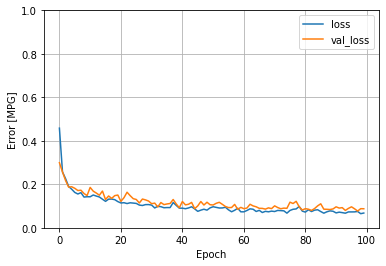

In [26]:
plot_loss(history)

In [27]:
avg_loss = dnn_model.evaluate(np.asarray(test_features).astype(np.float32),
                              np.asarray(test_labels).astype(np.float32))
print('Average loss:', avg_loss)

6/6 [==============================] - 0s 1ms/step - loss: 0.0788
Average loss: 0.07882864028215408


In [28]:
dnn_model.save('mouth_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mouth_model/assets


In [29]:
def test_random_landmark():
    row = raw_dataset.sample()
    mu = row['mu'].iloc[0]
    row.pop('mu')
    landmark = np.array([np.asarray(row)[0].astype(np.float32)])
    predicted_mu = dnn_model.predict(landmark)
    print('mu:', mu)
    print('predicted_mu:', predicted_mu)

In [35]:
test_random_landmark()

mu: 0.1306553840637207
predicted_mu: [[0.0493105]]
